processing time : 0.009610652923583984 s
processing time : 0.0035729408264160156 s


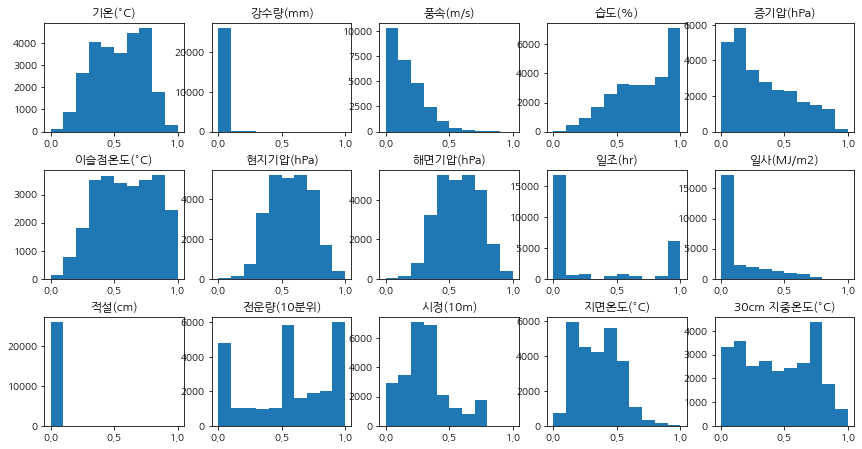

In [1]:

'''
기온(°C)  ->  spline
강수량(mm)  ->  0 + 분자료
풍속(m/s)  ->  spline
습도(%)  ->  spline
증기압(hPa)  ->  spline
이슬점온도(°C)  ->  spline
현지기압(hPa)  ->  spline
해면기압(hPa)  ->  spline
일조(hr)  ->  0
일사(MJ/m2)  ->  0
적설(cm)  ->  0
전운량(10분위)  ->  linear
시정(10m)  ->  spline
지면온도(°C)  ->  spline
지중온도(°C)  ->  ?
'''

# 관측 데이터 처리

import pandas as pd
import numpy as np
import utils


data_obs = pd.read_csv('data_obs.csv')


# 관측데이터 컬럼별 보간 방법 및 노멀라이즈 여부 결정과 풍향 더미화 진행

c_spline = ['기온(°C)', '풍속(m/s)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)','해면기압(hPa)', 
            '지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)','20cm 지중온도(°C)', '30cm 지중온도(°C)', "시정(10m)"]

c_linear = ['전운량(10분위)', "풍향(16방위)"]

# spline 보간 좀 오래걸림. 실험할 때 귀찮으면 linear 돌려서 실험하는거 추천
utils.dataframe_interpolation_by_linear(data_obs, c_spline) 
utils.dataframe_interpolation_by_linear(data_obs, c_linear)

value = {"강수량(mm)":0, "적설(cm)":0, "일조(hr)":0, "일사(MJ/m2)":0, 
         "전운량(10분위)":np.mean(data_obs["전운량(10분위)"]), "시정(10m)":np.mean(data_obs["시정(10m)"])}


data_obs.fillna(value, inplace=True)


data_obs = utils.wind_direction_dummies(data_obs, "풍향(16방위)", True)



import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'


exclude_column_list = ["time", "5cm 지중온도(°C)", "10cm 지중온도(°C)", "20cm 지중온도(°C)", "풍향(16방위)_1.0", "풍향(16방위)_2.0", "풍향(16방위)_3.0", "풍향(16방위)_4.0",
                       "풍향(16방위)_5.0", "풍향(16방위)_6.0", "풍향(16방위)_7.0", "dangjin_floating"]


data_obs = utils.dataframe_normalize(data_obs, exclude_column_list)

utils.hist_features(data_obs, exclude_column_list)






processing time : 5.397302150726318 s
processing time : 0.013340950012207031 s


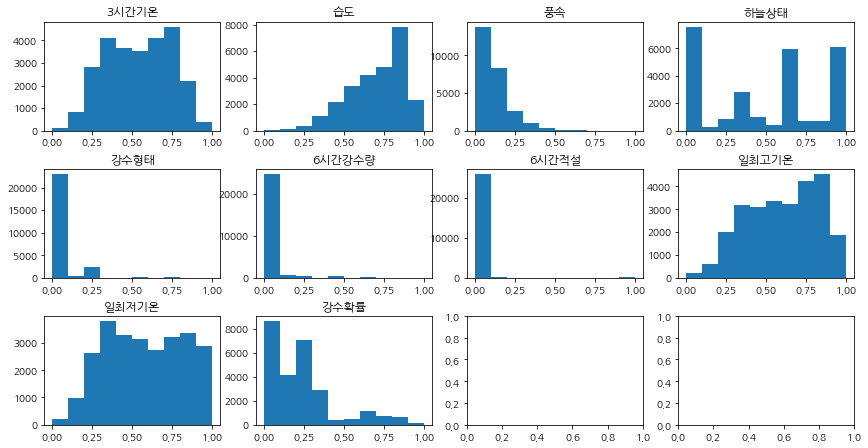

In [2]:

'''
3시간기온 --> pass + spline
습도 --> pass + spline
풍향 --> pass + linear + 8방위 변환 + 더미화
풍속 --> pass + spline
하늘상태 --> pass + linear
강수형태 --> pass + linear
6시간강수 --> 배분하기.
6시간적설 --> 배분하기.
일최고기온 --> pass + spline
일최저기온 --> pass + spline
강수확률 --> pass + linear
'''

# 예보 데이터 처리

# 3시간 간격 -> 1시간 간격, 강수량 배분, 컬럼별 보간 및 노멀라이즈, 풍향 더미화 

data_fcst = pd.read_csv('data_fcst.csv')


data_fcst = utils.fcst_augment(data_fcst)

data_fcst = utils.divide_cumulative_rainfall(data_fcst)


utils.dataframe_interpolation_by_spline(data_fcst, ["3시간기온", "습도", "일최고기온", "일최저기온"])
utils.dataframe_interpolation_by_linear(data_fcst, ["풍향", "풍속", "하늘상태", "강수형태", "강수확률", "6시간강수량", "6시간적설"])

data_fcst = utils.dataframe_normalize(data_fcst, ["time_index", "풍향"])

data_fcst = utils.wind_direction_dummies(data_fcst, "풍향", False)



# "풍향_1.0", "풍향_2.0", "풍향_3.0", "풍향_4.0", "풍향_5.0", "풍향_6.0", "풍향_7.0"

utils.hist_features(data_fcst, ["time_index", "풍향_1.0", "풍향_2.0", "풍향_3.0", "풍향_4.0", "풍향_5.0", "풍향_6.0", "풍향_7.0"])

<AxesSubplot:>

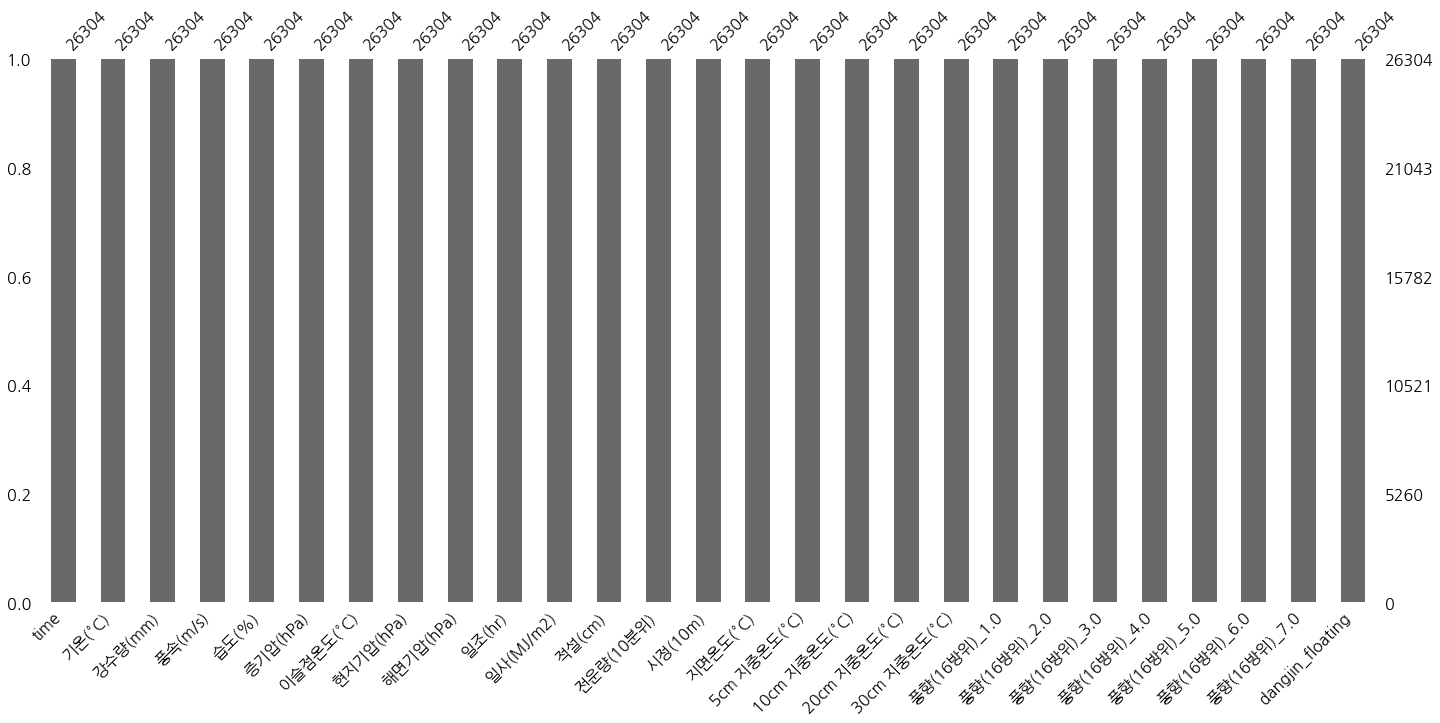

In [3]:
import missingno as msno

msno.bar(data_obs)



/home/donggyu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/donggyu/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

/home/donggyu/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)


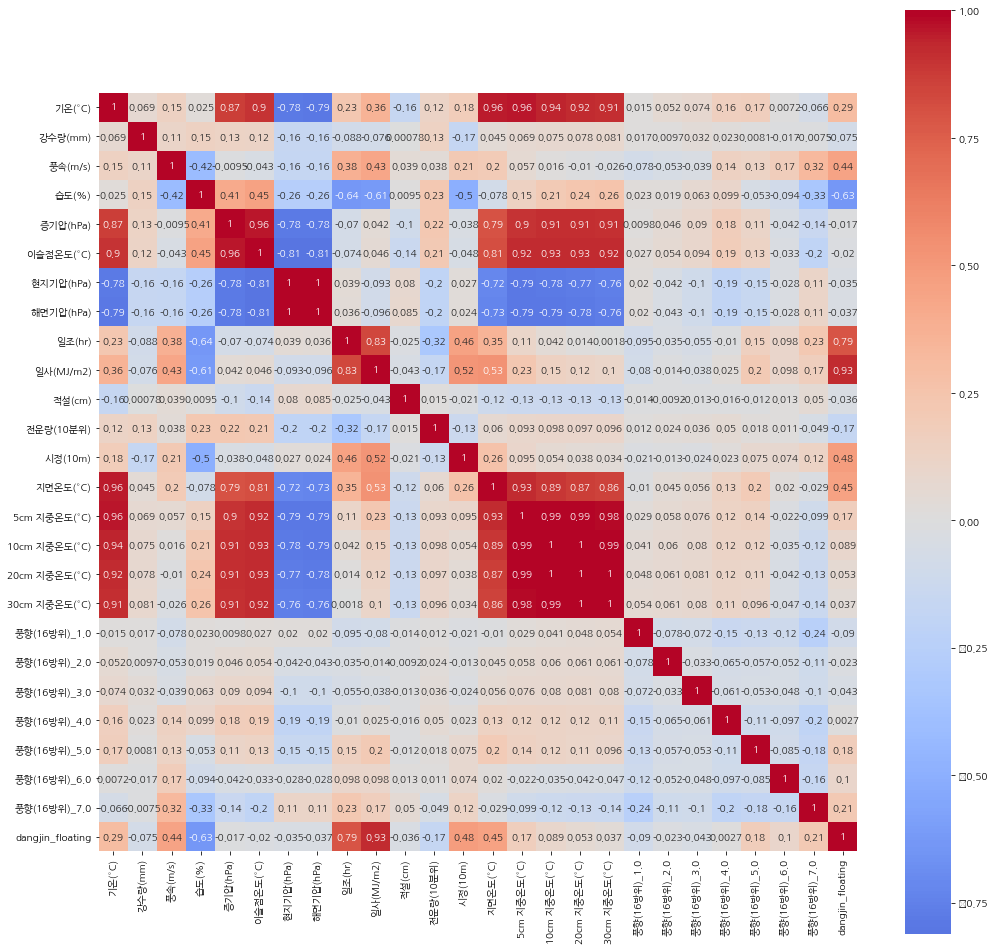

In [4]:
import seaborn as sns

plt.figure(figsize=(17, 17))
correlations = data_obs.corr(method='pearson')
sns.heatmap(correlations, cmap="coolwarm", square=True, center=0, annot=True)



In [5]:


# feature selection 부분

obs_select = list(data_obs.columns)    # 관측 데이터 중 포함시킬 컬럼
fcst_select = list(data_fcst.columns)  # 예보 데이터 중 포함시킬 컬럼

ndays = 2  # 과거 몇 일의 데이터를 포함해 현재의 예측에 반영해줄 것인지


inputs, outputs = utils.data_transform(data_obs, data_fcst, ndays, obs_select, fcst_select)



In [6]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import Model

dataset = TensorDataset(inputs, outputs)
train_dataset, valid_dataset = random_split(dataset, [1066-ndays, 30])
train_dataloader = DataLoader(train_dataset, batch_size=64)
valid_dataloader = DataLoader(valid_dataset, batch_size=30)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 모델 내부 하이퍼 파라미터 설정 부분

config = {'ndays' : ndays,
          'obs_input_size': len(obs_select)-2,
          'fcst_input_size': len(fcst_select)-1,
          'obs_hidden_size': 50,
          'fcst_hidden_size': 50,
          'hidden_size': 50,
          'dropout_ratio':0.3}



model = Model.model(config).to(device)



In [7]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 100
best_valid_loss = float('inf')

for epoch in range(epochs):


    train_loss = utils.train(model, train_dataloader, device, optimizer)
    rmse, mae = utils.evaluate(model, valid_dataloader, device)

    if best_valid_loss > rmse :

        best_valid_loss = rmse
        torch.save(model.state_dict(), 'power generation forecast.pt')


    if epoch % 10 == 0 : 

        print(f'{epoch} epoch loss')
        print(f'Train |  {train_loss:.4f}    Valid | RMSE {rmse:.4f} | MAE {mae:.4f}')



tensor(209.4195, device='cuda:0') tensor(139.6267, device='cuda:0')
0 epoch loss
Train |  216.6816    Valid | RMSE 0.0000 | MAE 0.0000
tensor(175.9274, device='cuda:0') tensor(128.8453, device='cuda:0')
tensor(178.6737, device='cuda:0') tensor(122.2200, device='cuda:0')
tensor(175.8022, device='cuda:0') tensor(122.0004, device='cuda:0')
tensor(176.1398, device='cuda:0') tensor(121.2198, device='cuda:0')
tensor(175.8253, device='cuda:0') tensor(121.2206, device='cuda:0')
tensor(175.5202, device='cuda:0') tensor(121.1189, device='cuda:0')
tensor(175.2852, device='cuda:0') tensor(121.0668, device='cuda:0')
tensor(166.2970, device='cuda:0') tensor(115.4483, device='cuda:0')
tensor(123.5130, device='cuda:0') tensor(85.5411, device='cuda:0')
tensor(89.3233, device='cuda:0') tensor(51.6703, device='cuda:0')
10 epoch loss
Train |  103.0492    Valid | RMSE 0.0000 | MAE 0.0000
tensor(82.8714, device='cuda:0') tensor(47.7300, device='cuda:0')
tensor(80.1218, device='cuda:0') tensor(44.6490, devic

In [8]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 100
best_valid_loss = float('inf')

for epoch in range(epochs):


    train_loss = utils.train(model, train_dataloader, device, optimizer)
    rmse, mae = utils.evaluate(model, valid_dataloader, device)

    if best_valid_loss > rmse :

        best_valid_loss = rmse
        torch.save(model.state_dict(), 'power generation forecast.pt')


    if epoch % 10 == 0 : 

        print(f'{epoch} epoch loss')
        print(f'Train |  {train_loss:.4f}    Valid | RMSE {rmse:.4f} | MAE {mae:.4f}')



tensor(84.2188, device='cuda:0') tensor(40.6200, device='cuda:0')
0 epoch loss
Train |  57.7422    Valid | RMSE 0.0000 | MAE 0.0000
tensor(81.5678, device='cuda:0') tensor(39.8157, device='cuda:0')
tensor(78.7156, device='cuda:0') tensor(39.6914, device='cuda:0')
tensor(85.8110, device='cuda:0') tensor(42.1691, device='cuda:0')
tensor(88.9533, device='cuda:0') tensor(44.7514, device='cuda:0')
tensor(86.1584, device='cuda:0') tensor(42.9304, device='cuda:0')
tensor(84.6748, device='cuda:0') tensor(42.1654, device='cuda:0')
tensor(79.4145, device='cuda:0') tensor(39.8091, device='cuda:0')
tensor(83.5477, device='cuda:0') tensor(41.9713, device='cuda:0')
tensor(80.8942, device='cuda:0') tensor(41.6761, device='cuda:0')
tensor(83.5378, device='cuda:0') tensor(41.5409, device='cuda:0')
10 epoch loss
Train |  52.1896    Valid | RMSE 0.0000 | MAE 0.0000
tensor(86.1964, device='cuda:0') tensor(43.0564, device='cuda:0')
tensor(84.0649, device='cuda:0') tensor(42.7197, device='cuda:0')
tensor(83